# Gaussian Processes

Gaussian process is an infinite collection of random variables, any finite number of which have a joint Gaussian distribution (due to consistency or marginalisation property of Gaussian distributions).

Task is to infer the function $f(\cdot)$ from a data $\mathcal{D}=\{y_i,x_i\}_{i=1}^N$: $y_i=f(x_i) + \epsilon$ where $\epsilon$ is Gaussian i.i.d noise with variance $\sigma_n^2$

Likelihood for indendent data: $p(y|f(x))=\prod_{i=1}^N p(y_i|f(x_i))$

GP prior over functions evaluated at the input locations which are jointly Gaussian:

$$\begin{bmatrix}f_1 \\ f_2 \\ \vdots \\ f_N \end{bmatrix} \sim \mathcal{N}\ \left(\begin{bmatrix}\mu_1 \\ \mu_2 \\ \vdots \\ \mu_N \end{bmatrix},\begin{bmatrix}k(x_1,x_1) +\sigma_n^2 I & k(x_1,x_2) & \dots & k(x_1,x_N) \\ k(x_2,x_1) & k(x_2,x_2) +\sigma_n^2 I & \dots & k(x_2,x_N) \\ \vdots & \vdots & \dots & \vdots \\ k(x_N,x_1) & k(x_N,x_2) & \dots & k(x_N,x_N) +\sigma_n^2 I \end{bmatrix}\right)$$

Where $\mu(\cdot)$ is the mean function and $k(\cdot,\cdot)$ is the co-variance function or kernel. One example of a kernel is the squared exponential: $k(x,x^\prime)=\sigma^2 exp \left(\frac{-(x-x^\prime)^T(x-x^\prime)}{l^2}\right)$

Joint distribution of the training outputs $f$ and test outputs $f_*$ according to the prior is:

$$\begin{bmatrix}f \\ f_* \end{bmatrix} \sim \mathcal{N}\ \left(0, \begin{bmatrix}k(X,X) +\sigma_n^2 I & k(X,X_*) \\ k(X_*,X) & k(X_*,X_*) \end{bmatrix}\right)$$

The posterior is found by conditioning the joint Gaussian prior distribution on the observations: $p(f_*|f,X_*,X) = \mathcal{N}(\mu_{X_*|X},K_{X_*|X})$ where $\mu_{X_*|X}=k(x_*,x)(k(x,x)+\sigma_n^2I)^{-1}f$ and $K_{X_*|X}=k(x_*,x_*)-k(x_*,x)(k(x,x)+\sigma_n^2I)^{-1}k(x,x_*)$

To tune the kernel hyperparameters ($l, \sigma^2, \sigma_n^2$) then maximise the marginal log likelihood: $log\ p(f|X)=-\frac12 f^T(k+\sigma_n^2 I)^{-1}f - \frac12 log|k+\sigma_n^2| -\frac{n}{2} log 2\pi$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.patches import Ellipse
from scipy.stats import norm
from scipy.spatial.distance import cdist
import torch

In [3]:
def plot_gaussian(mu, sigma, n_std=2):
    fig, ax = plt.subplots(figsize=(5, 5))
    samples = np.random.multivariate_normal(mu, sigma, 1000)
    ax.scatter(samples[:, 0], samples[:, 1], s=10)
    lam, u = np.linalg.eig(sigma)
    theta = np.arctan(u[0, 0] / (u[1, 0])+1e-10) / (2*np.pi) * 360
    for i in range(1, n_std+1):
        ellipse = Ellipse((mu[0], mu[1]), width=2*lam[0]**(1/2)*i, height=2*lam[1]**(1/2)*i,
                          angle=theta, fill=None)
        ax.add_patch(ellipse)
    ax.set_xlim(-4, 4), ax.set_ylim(-4, 4)
    ax.set_xlabel("x1"), ax.set_ylabel("x2")
    plt.show()

/var/folders/xq/vn60xb7s2cd4ggcbjcn35s4dpzfmr3/T/ipykernel_57893/1277276229.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(u[0, 0] / (u[1, 0])+1e-10) / (2*np.pi) * 360


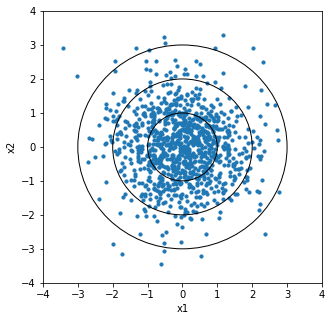

In [4]:
mu = np.array([0,0])
sigma = np.array([[1,0],[0,1]])
plot_gaussian(mu, sigma, n_std=3)

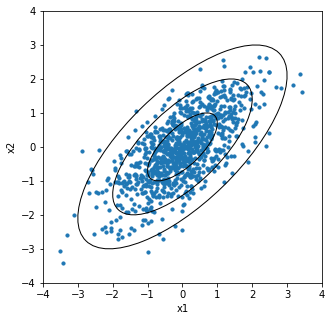

In [5]:
sigma = np.array([[1,0.7],[0.7,1]])
plot_gaussian(mu, sigma, n_std=3)

In [6]:
def plot_conditioning(mu, sigma, cond_dim, cond_value, n_std=3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    lam, u = np.linalg.eig(sigma)
    theta = np.arctan(u[0, 0] / (u[1, 0])+1e-10) / (2*np.pi) * 360
    for i in range(1, n_std+1):
        ellipse = Ellipse((mu[0], mu[1]), width=2*lam[0]**(1/2)*i, height=2*lam[1]**(1/2)*i,
                          angle=theta, fill=None)
        ax1.add_patch(ellipse)
    ax1.set_xlim(-4, 4), ax1.set_ylim(-4, 4)
    ax1.set_xlabel("x1"), ax1.set_ylabel("x2")

    plot_dim = 1 - cond_dim
    cond_line = np.array([[cond_value, cond_value], [-4, 4]])
    ax1.plot(cond_line[cond_dim, :], cond_line[plot_dim, :])
    x = np.linspace(-4, 4, 1000)
    ax2.plot(x, norm.pdf(x, loc=mu[plot_dim], scale=sigma[plot_dim, plot_dim]),
             label=f"p(x{plot_dim+1})")
    cond_mu = mu[plot_dim] + sigma[plot_dim, cond_dim] * float(sigma[cond_dim, cond_dim])**-1 * \
              (cond_value - mu[cond_value])
    cond_sigma = sigma[plot_dim, plot_dim] - sigma[plot_dim, cond_dim] * \
                 float(sigma[cond_dim, cond_dim])**-1 * sigma[cond_dim, plot_dim]
    ax2.plot(x, norm.pdf(x, loc=cond_mu, scale=cond_sigma),
             label=f"p(x{plot_dim+1}|x{cond_dim+1}={cond_value})")
    ax2.set_xlabel(f"x{plot_dim+1}")
    ax2.legend()
    plt.show()

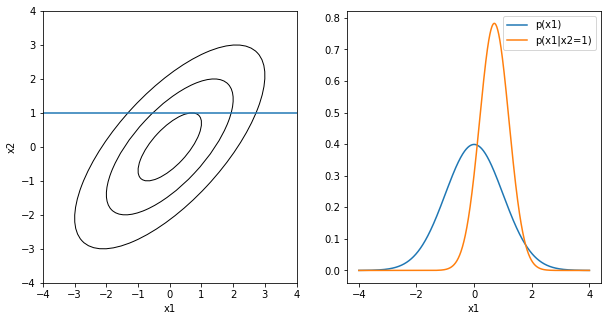

In [7]:
mu = np.array([0, 0])
sigma = np.array([[1, 0.7], [0.7, 1]])
plot_conditioning(mu, sigma, cond_dim=1, cond_value=1)

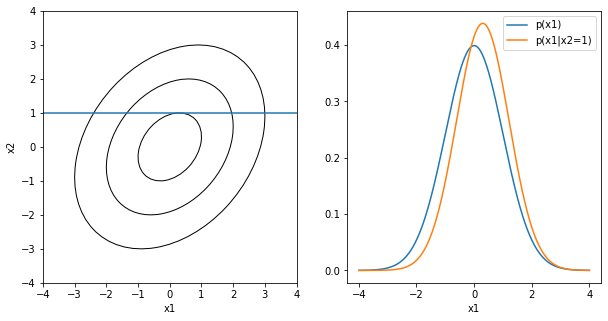

In [8]:
sigma = np.array([[1, 0.3], [0.3, 1]])
plot_conditioning(mu, sigma, cond_dim=1, cond_value=1)

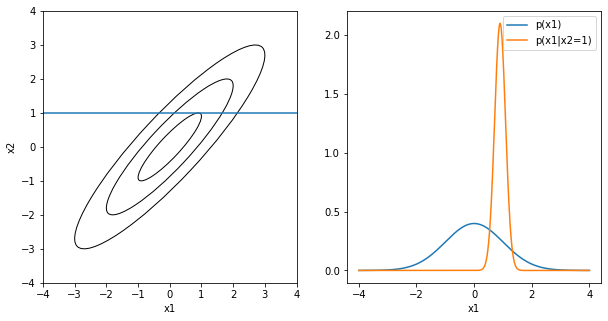

In [9]:
sigma = np.array([[1, 0.9], [0.9, 1]])
plot_conditioning(mu, sigma, cond_dim=1, cond_value=1)

In [10]:
def sample_plot(mu, sigma, n_sam=10):
    dim = len(mu)
    assert type(dim) is int and dim > 1

    samples = np.random.multivariate_normal(mu, sigma, n_sam)
    if dim == 2:
        fig, (ax1, ax) = plt.subplots(1, 2, figsize=(10, 5))
        lam, u = np.linalg.eig(sigma)
        theta = np.arctan(u[0, 0] / (u[1, 0])+1e-10) / (2*np.pi) * 360
        for i in range(1, 4):
            ellipse = Ellipse((mu[0], mu[1]), width=2*lam[0]**(1/2)*i, height=2*lam[1]**(1/2)*i,
                              angle=theta, fill=None)
            ax1.add_patch(ellipse)
        ax1.set_xlim(-4, 4), ax1.set_ylim(-4, 4)
        ax1.set_xlabel("x1"), ax1.set_ylabel("x2")
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        ax1.scatter(samples[:, 0], samples[:, 1], c=colors[:n_sam])
    else:
        fig, ax = plt.subplots(figsize=(5, 5))

    ax.plot(np.tile(np.arange(1, dim+1), reps=(n_sam, 1)).T, samples.T, marker='o')
    plt.show()

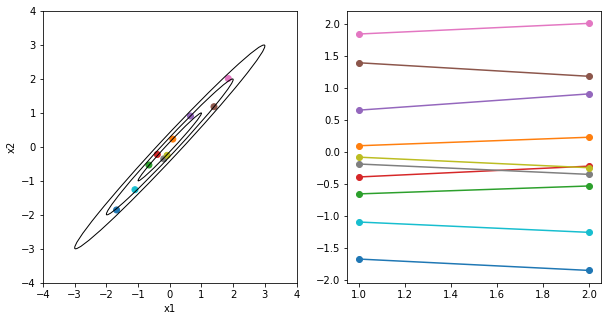

In [11]:
mu = np.zeros(2)
sigma = np.array([[1, 0.99], [0.99, 1]])
sample_plot(mu, sigma, n_sam=10)

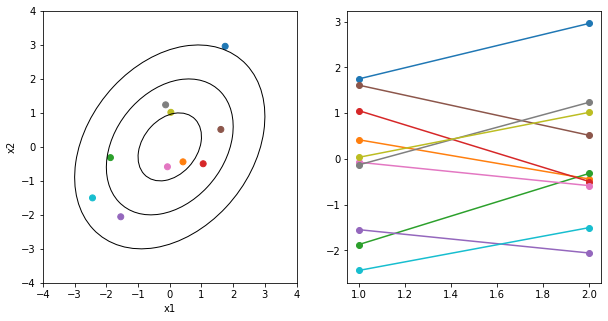

In [12]:
sigma = np.array([[1, 0.3], [0.3, 1]])
sample_plot(mu, sigma, n_sam=10)

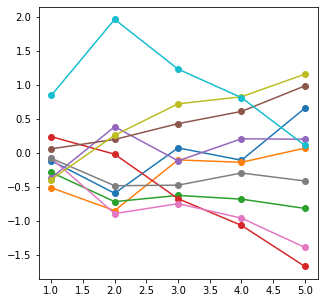

In [13]:
mu = np.zeros(5)
sigma = np.array(
    [[1, 0.9, 0.8, 0.6, 0.4],
     [0.9, 1, 0.9, 0.8, 0.6],
     [0.8, 0.9, 1, 0.9, 0.8],
     [0.6, 0.8, 0.9, 1, 0.9],
     [0.4, 0.6, 0.8, 0.9, 1]
     ])
sample_plot(mu, sigma, 10)


In [14]:
def sample_plot_with_cond(mu, sigma, n_sam=10, cond_dim=np.array([0]), cond_value=np.array([0])):
    dim = len(mu)
    assert dim > 2
    other_dims = np.arange(len(cond_dim), dim)

    if len(cond_dim) == 1:
        mu = mu[other_dims] + sigma[other_dims, cond_dim] *\
                  float(sigma[cond_dim, cond_dim])**-1 * (cond_value - mu[cond_dim])
        sigma = sigma[other_dims][:, other_dims] - sigma[other_dims, cond_dim].reshape(-1, 1) @ \
                (float(sigma[cond_dim, cond_dim])**-1 * sigma[cond_dim, other_dims].reshape(1, -1))
    else:
        mu = mu[other_dims] + sigma[other_dims][:, cond_dim] @ \
             np.linalg.inv(sigma[cond_dim][:, cond_dim]) @ (cond_value - mu[cond_dim])
        sigma = sigma[other_dims][:, other_dims] - sigma[other_dims][:, cond_dim] @ \
                np.linalg.inv(sigma[cond_dim][:, cond_dim]) @ sigma[cond_dim][:, other_dims]

    samples = np.random.multivariate_normal(mu.flatten(), sigma, n_sam)
    samples = np.concatenate((np.tile(cond_value, reps=(n_sam, 1)), samples), axis=1)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(np.tile(np.arange(1, dim+1), reps=(n_sam, 1)).T, samples.T, marker='o')
    plt.show()

/var/folders/xq/vn60xb7s2cd4ggcbjcn35s4dpzfmr3/T/ipykernel_57893/584645894.py:17: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu.flatten(), sigma, n_sam)


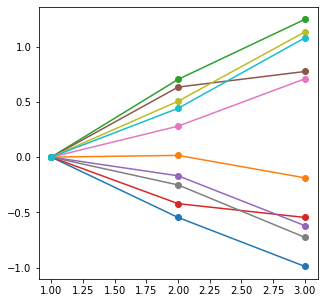

In [15]:
mu = np.zeros(3)
sigma = np.array([[1, 0.9, 0.6], [0.9, 1, 0.9], [0.6, 0.9, 1]])
sample_plot_with_cond(mu, sigma, n_sam=10)

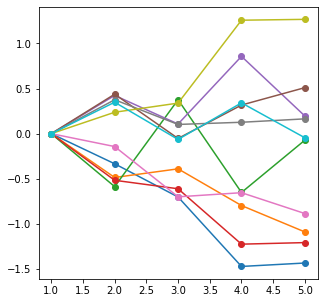

In [16]:
mu = np.zeros(5)
sigma = np.array(
    [[1, 0.9, 0.8, 0.6, 0.4],
     [0.9, 1, 0.9, 0.8, 0.6],
     [0.8, 0.9, 1, 0.9, 0.8],
     [0.6, 0.8, 0.9, 1, 0.9],
     [0.4, 0.6, 0.8, 0.9, 1]
     ])
sample_plot_with_cond(mu, sigma, n_sam=10)

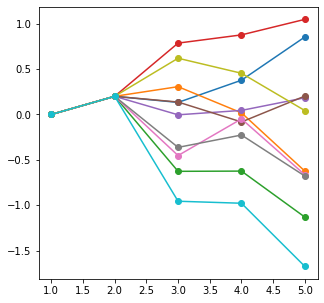

In [17]:
sample_plot_with_cond(mu, sigma, n_sam=10, cond_dim=np.array([0, 1]), cond_value=np.array([0, 0.2]))

In [18]:
def rbf_kernel(var, l):
    return lambda x1, x2: var * np.exp(-np.power(cdist(x1, x2), 2) / l**2)

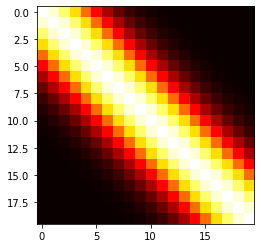

In [19]:
kernel = rbf_kernel(var=1, l=5)
size = 20
x = np.arange(1, size+1).reshape(-1, 1)
cov = kernel(x, x)
plt.imshow(cov, cmap='hot', interpolation='nearest')
plt.show()

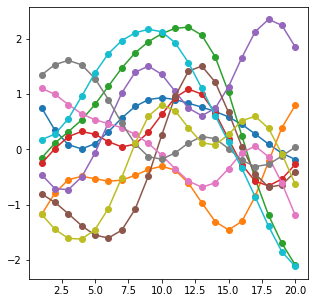

In [20]:
sample_plot(np.zeros(len(cov)), cov)

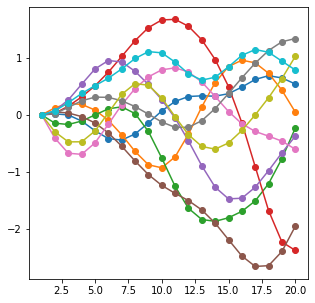

In [21]:
sample_plot_with_cond(np.zeros(len(cov)), cov)

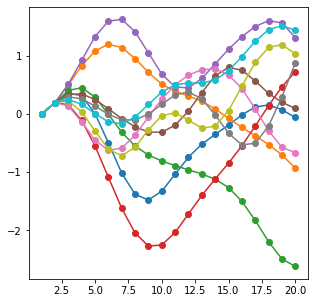

In [22]:
sample_plot_with_cond(np.zeros(len(cov)), cov, cond_dim=np.array([0, 1]),
                      cond_value=np.array([0, 0.2]))

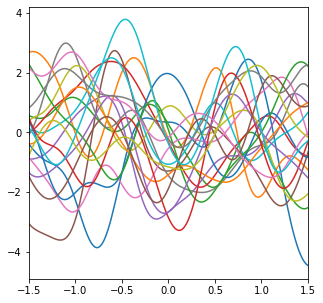

In [42]:
size = 200
x = np.linspace(-2, 2, size).reshape(-1, 1)
kernel = rbf_kernel(var=2, l=0.4)
cov = kernel(x, x)
n_sam = 20
samples = np.random.multivariate_normal(np.zeros(len(cov)), cov, n_sam)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.tile(x, reps=(1, n_sam)), samples.T)
ax.set_xlim(-1.5, 1.5)
plt.show()

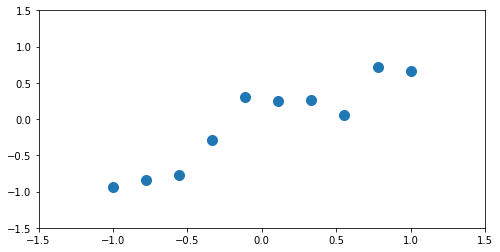

In [43]:
n = 10
x = np.concatenate((np.ones((n, 1)), np.linspace(-1, 1, n).reshape(-1, 1)), axis=1)
w = np.array([-0.1, 0.8])
var_gen = 0.2
y = np.random.normal(x @ w, var_gen, x.shape[0])
var_n = 0.1
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlim(-1.5, 1.5), ax.set_ylim(-1.5, 1.5)
ax.scatter(x[:, 1], y, s=100)
plt.show()

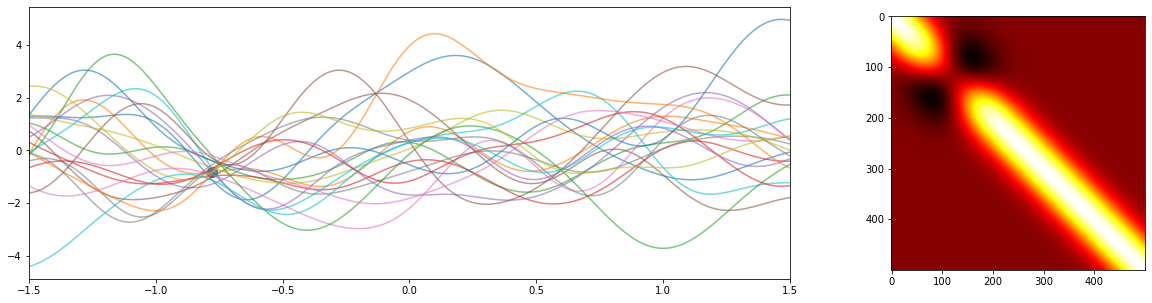

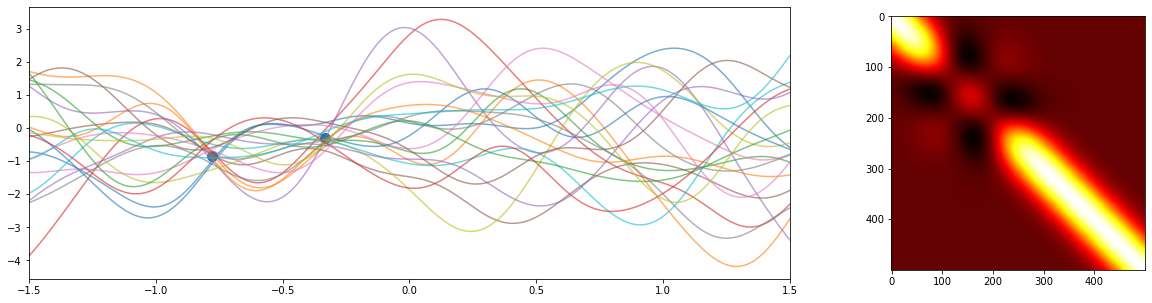

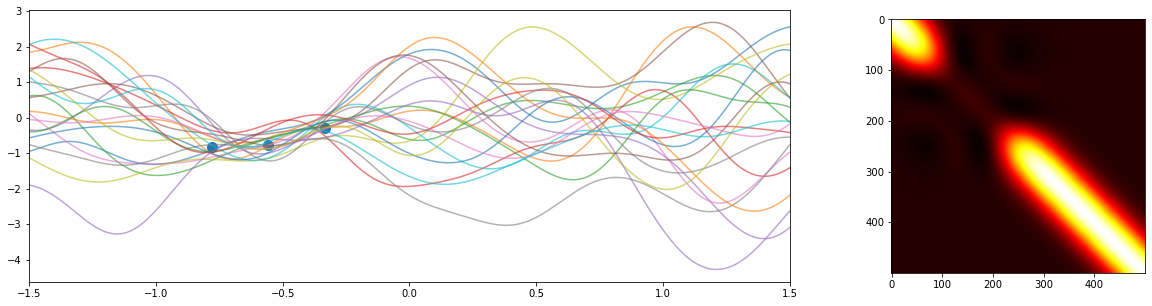

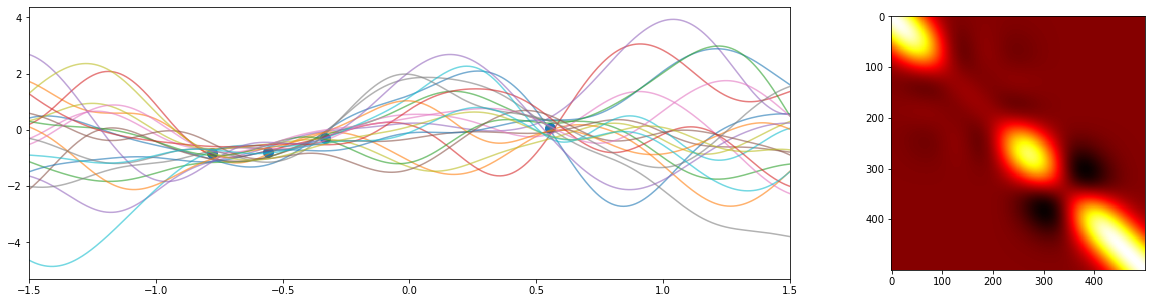

In [44]:
x_star = np.linspace(-1.5, 1.5, 500).reshape(-1, 1)

def gp_prediction(x, y, x_star, kernel, var_n):
    mu = kernel(x_star, x) @ np.linalg.inv(kernel(x, x) + var_n * np.identity(len(x))) @ y
    cov = kernel(x_star, x_star) - kernel(x_star, x) @ np.linalg.inv(kernel(x, x) + var_n * np.identity(len(x))) @ kernel(x, x_star)
    return mu, cov

n_sam = 20
idx = np.random.permutation(np.arange(len(x)))[:5]
for i in range(1, len(idx)):
    x_sam = x[idx[:i], 1].reshape(-1, 1)
    y_sam = y[idx[:i]]
    mu, cov = gp_prediction(x_sam, y_sam, x_star, kernel, var_n)
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [3, 1]})
    samples = np.random.multivariate_normal(mu, cov, n_sam)
    ax.scatter(x_sam, y_sam, s=100)
    ax.plot(np.tile(x_star, reps=(1, n_sam)), samples.T, alpha=0.6)
    ax2.imshow(cov, cmap='hot', interpolation='nearest')
    ax.set_xlim(-1.5, 1.5)
    plt.show()

(-1.5, 1.5)

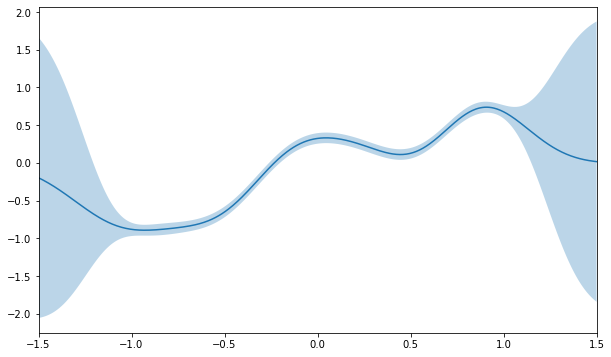

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))
mu, cov = gp_prediction(x[:, 1].reshape(-1, 1), y, x_star, kernel, var_n)
ax.plot(x_star, mu)
ax.fill_between(x_star.flatten(), mu-np.diag(cov), mu+np.diag(cov), alpha=0.3)
ax.set_xlim(-1.5, 1.5)

In [39]:
def torch_rbf_kernel(var, l):
    return lambda x1, x2: var * torch.exp(-torch.pow(torch.cdist(x1, x2), 2) / l**2)

def marg_log_likelihood(x, y, kernel, var_n):
    k_n = kernel(x, x) + var_n * torch.eye(len(x))
    return  - 1/2 * y.T @ torch.inverse(k_n)  @ y - 1/2 * torch.log(torch.norm(k_n)) - len(x)/2 * torch.log(torch.tensor(2*torch.pi))

x_torch = torch.as_tensor(x)
y_torch = torch.as_tensor(y)
params = torch.tensor([0.5, 0.2, 0.2], requires_grad=True)
kernel_torch = torch_rbf_kernel(var=params[0], l=params[1])
mll = marg_log_likelihood(x_torch, y_torch, kernel_torch, var_n=params[2])
print(params, mll)

tensor([0.5000, 0.2000, 0.2000], requires_grad=True) tensor(-12.1227, dtype=torch.float64, grad_fn=<SubBackward0>)


tensor([0.8534, 0.5799, 0.5481], requires_grad=True) tensor(-10.9425, dtype=torch.float64, grad_fn=<SubBackward0>)


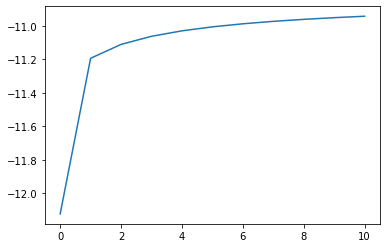

In [40]:
optimizer = torch.optim.SGD([params], lr=0.05)
epochs = 10
all_mll = np.zeros(epochs+1)
all_mll[0] = mll
for i in range(epochs):
    optimizer.zero_grad()
    (-mll).backward()
    optimizer.step()
    mll = marg_log_likelihood(x_torch, y_torch, kernel_torch, var_n=params[2])
    all_mll[i+1] = mll.detach().numpy()
print(params, mll)
fig, ax = plt.subplots()
ax.plot(all_mll)
plt.show()

(-1.5, 1.5)

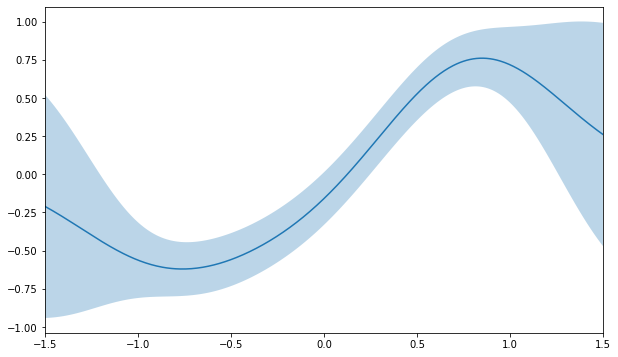

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
kernel = rbf_kernel(params.detach().numpy()[0], params.detach().numpy()[1])
mu, cov = gp_prediction(x[:, 1].reshape(-1, 1), y, x_star, kernel, params.detach().numpy()[2])
ax.plot(x_star, mu)
ax.fill_between(x_star.flatten(), mu-np.diag(cov), mu+np.diag(cov), alpha=0.3)
ax.set_xlim(-1.5, 1.5)